In [2]:
import numpy as np
import xarray as xr
import pickle as pk
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy.interpolate import interp1d
import cartopy
from sklearn.metrics import r2_score as r2_score
import cartopy.crs as ccrs
from sklearn.linear_model import LinearRegression as lr 
from cartopy.util import add_cyclic_point
import matplotlib as mpl
mpl.rc('font',size=16,**{'family':'sans-serif','sans-serif':['Arial']})

In [3]:
wd = '/Volumes/eSSD0/Papers/JoC_gFBK/Data/'
control = pk.load(open(wd+'Outputs/b.e12.pi-control.T31_g37.ctl.2_diag_grid_int.pk','rb'))
cld_kernel = pk.load(open(wd+'Kernels/cloud_kernels_T31.pk','rb'))
cld_kernel['LWkernel_swap'] = np.swapaxes(cld_kernel['LWkernel'],1,2)

albcs = np.arange(0.0, 1.1, 0.5)

SWkernel_map = np.zeros([12, 7, 7, 48, 96])
for m in range(12):  # loop through months
    for la in range(46):  # loop through longitudes

        # pluck out a zonal slice of clear sky surface albedo
        alb_lon = np.nanmean(control['csalb'],axis=0)[m, la, :]/100

        #remap the kernel onto the same grid as the model output
        function = interp1d(albcs, cld_kernel['SWkernel'][m, :, :, la, :], axis=2, kind='linear')
        new_kernel_lon = function(alb_lon)
        SWkernel_map[m, :, :, la, :] = new_kernel_lon

lat = control.pop('lat')
lon = control.pop('lon')

cld_kernel['SWkernel_swap'] = np.swapaxes(SWkernel_map,1,2)

/var/folders/cg/kl9yj43d2mvfb7blrzr2thg00000gn/T/ipykernel_43790/139784201.py:13: RuntimeWarning: Mean of empty slice
  alb_lon = np.nanmean(control['csalb'],axis=0)[m, la, :]/100


In [7]:
tau = [0.,0.3,1.3,3.6,9.4,23.,60.,380.]
ctp = [1000,800,680,560,440,310,180,50]

y = lat*np.pi/180
coslat = np.cos(y)
coslat_isccp = np.tile(coslat[None,None,:,None],(7,7,1,lon.size))

sw_gam = np.average(np.nanmean(cld_kernel['SWkernel_swap'],axis=0),axis=(2,3),weights=coslat_isccp)
lw_gam = np.average(np.nanmean(cld_kernel['LWkernel_swap'],axis=0),axis=(2,3),weights=coslat_isccp)

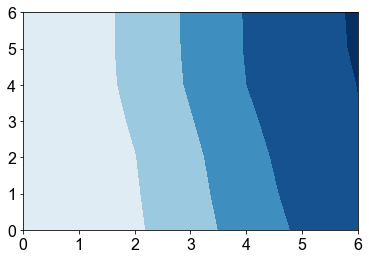

In [8]:
hist_spread = plt.contourf(sw_gam ,np.arange(-2,2.1,0.5),cmap=plt.cm.RdBu_r,extend='both')

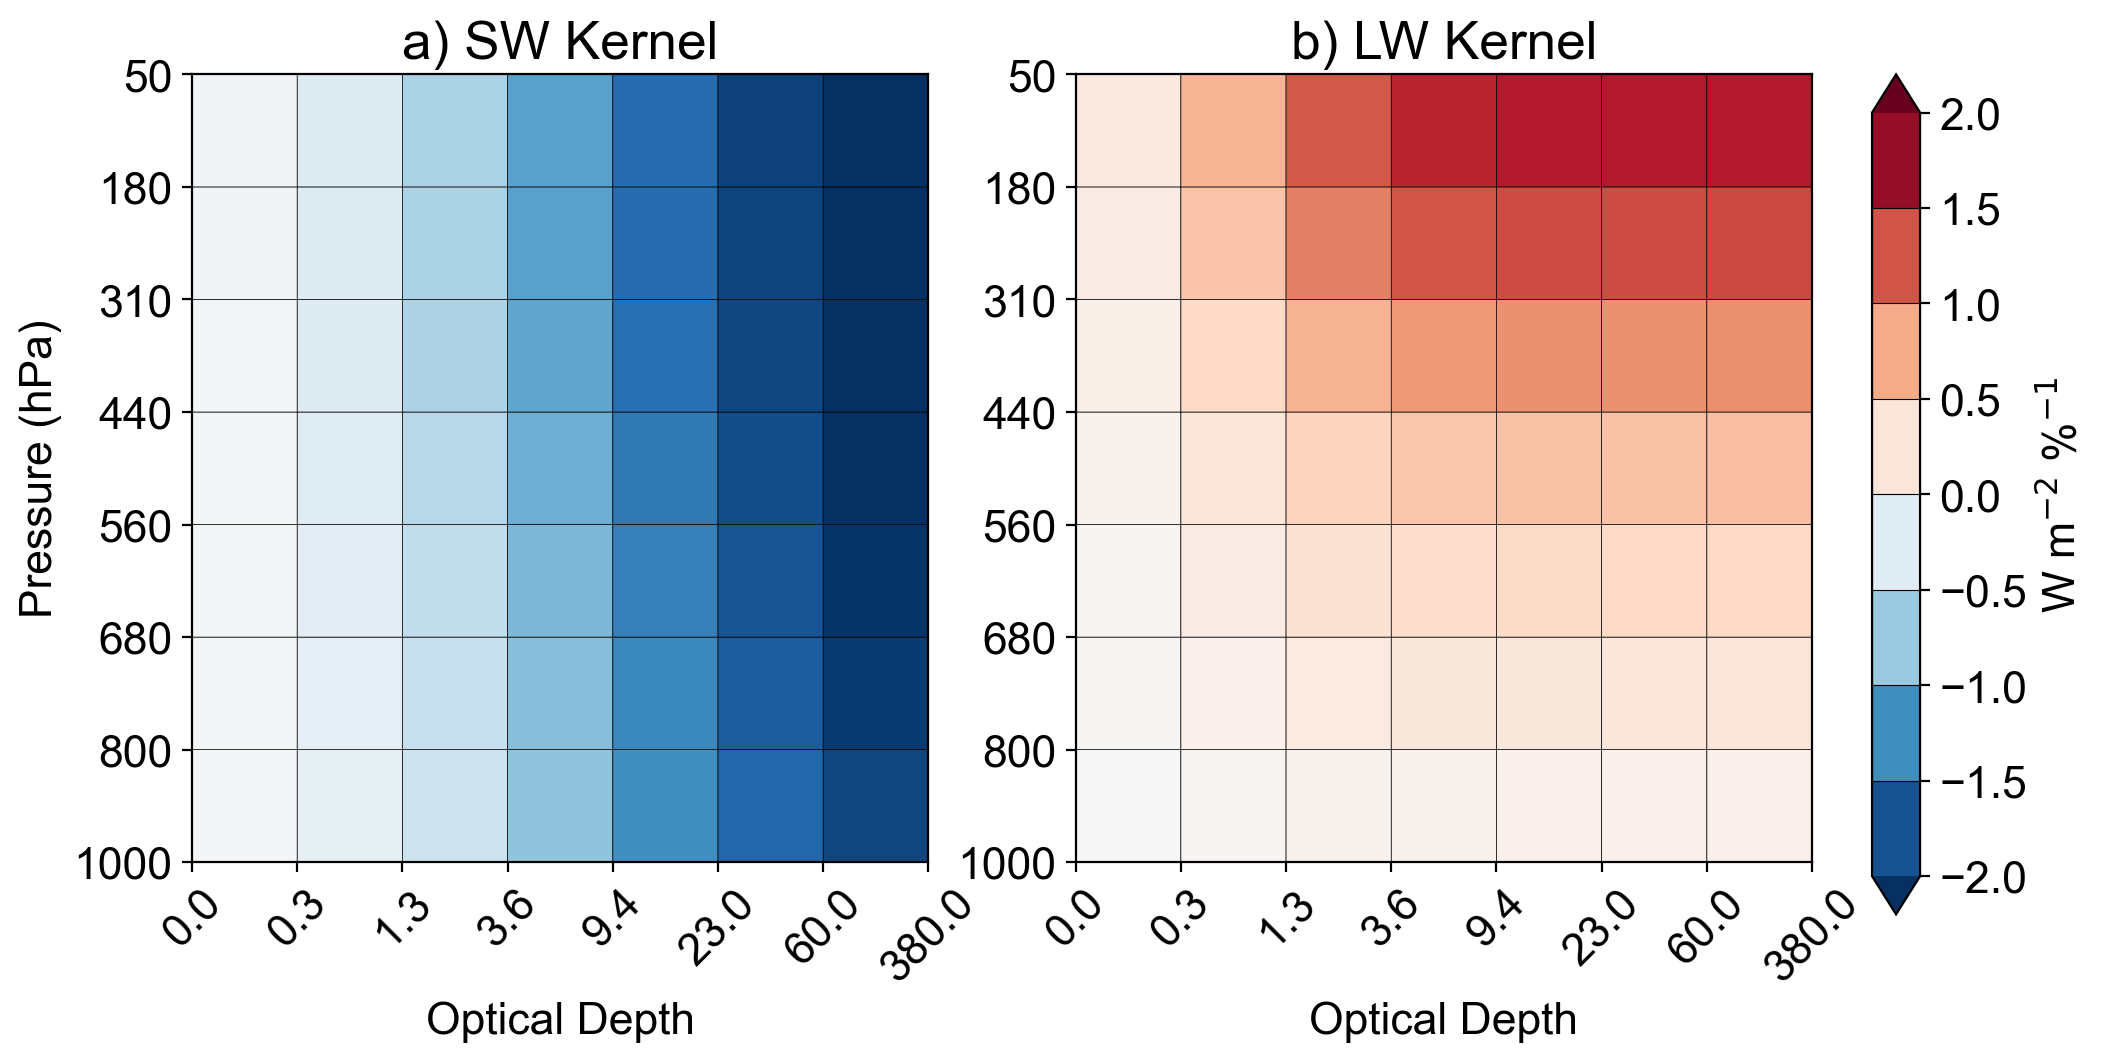

In [14]:
fig = plt.figure(figsize=(12,12),dpi=200)

plt.subplot(221)
plt.title('a) SW Kernel')
plt.pcolor(sw_gam,cmap=plt.cm.RdBu_r,vmin=-2,vmax=2,edgecolors='k')
plt.xticks(np.arange(8), tau,rotation=45)
plt.yticks(np.arange(8), ctp)
plt.xlabel('Optical Depth')
plt.ylabel('Pressure (hPa)')

plt.subplot(222)
plt.title('b) LW Kernel')
plt.pcolor(lw_gam,cmap=plt.cm.RdBu_r,vmin=-2,vmax=2,edgecolors='k')
plt.xticks(np.arange(8), tau,rotation=45)
plt.yticks(np.arange(8), ctp)
plt.xlabel('Optical Depth')

plt.subplots_adjust(hspace = 0.3,right=0.8)
cbar_ax = fig.add_axes([0.825, 0.53, 0.02, 0.35])
fig.colorbar(hist_spread, cax=cbar_ax,drawedges=True,label='W m$^{-2}$ %$^{-1}$', orientation='vertical')

plt.savefig('Kernels_gam.png',bbox_inches='tight')